<a href="https://colab.research.google.com/github/VAnufrikov/doing_data_science/blob/master/%D0%9F%D1%80%D0%BE%D1%82%D0%BE%D1%82%D0%B8%D0%BF_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/e0xextazy/basic-feature-preprocessing-stacking-upgraded

https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

https://www.kaggle.com/code/mathchi/churn-problem-for-bank-customer

#### Импорт либ

In [ ]:
!pip install catboost lightgbm --quiet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier

from pprint import pprint
from warnings import filterwarnings

import seaborn as sns


filterwarnings("ignore", category=FutureWarning)

#### Загрузка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Predict customer churn in a bank/churn.csv', sep=',')
target = df['Exited']
df = df.drop('Exited', axis=1)

#### EDA

Внутри препроцессинг нужно будет поменять для нашего набора фичей

##### Матрица корреляций

In [ ]:
def plot_corr(df):
    corr = df.corr()
    corr = (corr.abs()*10).round()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        corr,
        mask = mask,
        cmap = 'RdBu',
        center = 0,
        square = True,
        linewidths = 0.1,
        annot = True,
        annot_kws = {'size': 9},
        cbar_kws={'ticks': [i for i in range(10+1)]}
    )

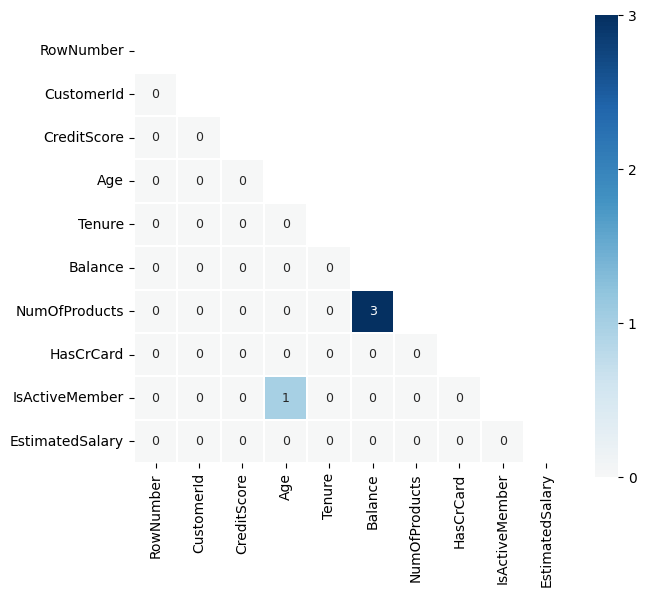

In [ ]:
plot_corr(df)

##### Дупликаты/пропуски

In [ ]:
print('Number of duplicated values in training dataset: ', df.duplicated().sum())

Number of duplicated values in training dataset:  0


In [ ]:
def data_prepare():
    df_prep = df.copy()


    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df = df_prep)


    df_prep['Tenure'] =  df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] =  df_prep.NumOfProducts.astype(np.float)
    return df_prep

In [ ]:
def show_unique_count_variables(df):
    for index, value in df.nunique().items():
        print(str(index) + "\n\t\t\t:" + str(value))

###### Outlier Editing

In [ ]:
def show_outliers(df):

    #tüm sütünları yukardan bakarak  outlier feature'ları gözlemleme

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale = 0.7)
    fig, axes = plt.subplots(nrows = 2, ncols = 5, gridspec_kw =  dict(hspace=0.3), figsize = (12,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
    fig.suptitle('Observing Outliers', color = 'r', fontsize = 14)

Visualization of outliers according to the LOF method

In [ ]:
def lof_observation(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))

    scores_df.plot(stacked=True, xlim = [0,20], color='r', title='Visualization of outliers according to the LOF method', style = '.-');                # first 20 observe
    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

Outiler suppression

In [ ]:
def clear_outliers(df):

    #yas ve kredi_skoru baskılama

    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper


    #kredi_skoru

    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower

    return df

Outiler Process

In [ ]:
def outlier_process(df):
    #show_outliers(df = df)
    df_outlier = lof_observation(df = df)
    df_outlier = clear_outliers(df = df_outlier)
    return df_outlier

###### Dependent variable distribution

In [ ]:
def show_dependent_variable(df):
#     sns.countplot(data = df, x = dependent_variable_name, label = 'Count') \
#     .set_title(dependent_variable_name + ' dependent variable situation', fontsize = 18, color = 'r')
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x = 'Geography', hue = 'Exited',data = df, ax = axarr[0][0])
    sns.countplot(x = 'Gender', hue = 'Exited',data = df, ax = axarr[0][1])
    sns.countplot(x = 'HasCrCard', hue = 'Exited',data = df, ax = axarr[0][2])
    sns.countplot(x = 'IsActiveMember', hue = 'Exited',data = df, ax = axarr[1][0])
    sns.countplot(x = 'NumOfProducts', hue = 'Exited',data = df, ax = axarr[1][1])
    sns.countplot(x = 'Tenure', hue = 'Exited',data = df, ax = axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

Numeric columns distribution observation

In [ ]:
def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    #plt.subplots(figsize=(22,22))
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color = 'r' ,fontsize = 18)
    plt.show()

###### Status of other variables according to dependent variable

In [ ]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name] == 1]
    df_num_cols = df_dependent_var.select_dtypes(include = numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color = 'r', fontsize = 18)
    plt.show()

##### Categorical variables are observed according to the dependent variable

In [ ]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale = 0.7)
    fig, axes = plt.subplots(nrows = int( len(categorical_columns) / 2 ) , ncols = 2, figsize = (7,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x = df[col], hue = dependent_variable_name, data = df, ax = ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color = 'r', fontsize = 1)

##### The main method that started all data analysis

In [ ]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(df = df_outlier, categorical_columns = ["Gender","Geography","HasCrCard","IsActiveMember"])

#### Feature engineering

In [ ]:
# distinction is based on the number of different values in the column
columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)

print('Numerical fetures: ',numeric_columns)
print('Categorical fetures: ',categoric_columns)

##### Categorial feature to Embeddings (На случай если OHE породит огромную размерность матрицы признаков)


In [ ]:
class EntropyCategoricalEmbedder:
    """Unsupervised categorical embedder based on group counts and entropy calculation

    fit - get dictionary for the transformation of categorical objects into embeddings
    transform - map the dictionary onto your categorical dataset to get the embeddings
    """

    def __init__(self):
        self.substitute_dict = {} #resulting dictionary to transform the objects into embs

    def __repr__(self):
        return self.__class__.__name__ + "()"

    @staticmethod
    def cat_prep(data: pd.DataFrame) -> pd.DataFrame:
        """change category names for simplification

        format -> category-name_category-name
        """

        data_new = data.copy()
        for col in tqdm(data.columns):
          data_new[col] = data[col].apply(lambda x: col + '_' + str(x))
        return data_new

    def fit(self, df_train: pd.DataFrame, verbose: bool = True) -> EntropyCategoricalEmbedderObject: # we created this custom type earlier
        """Create dictionary to map on the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep)
        (each row is our object to get an embedding for)
        """

        feature_list = list(df_train.columns)
        df = df_train.copy()
        df['id'] = df.index
        for group_key in tqdm(feature_list):
            passive_keys = feature_list[:]
            passive_keys.remove(group_key)

            category_embedding_mapping = {}
            for passive_key in passive_keys:
                if verbose:
                    print('--- groupby: group_key - ', group_key, '### passive_key - ', passive_key, '---')
                group = df.groupby([group_key, passive_key])['id'].count()
                group = group.unstack().fillna(0)
                entropy_values = group.apply(entropy, axis=1)
                for cat, entropy_value in entropy_values.to_dict().items():
                    if cat in category_embedding_mapping:
                        category_embedding_mapping[cat].extend([entropy_value])
                    else:
                        category_embedding_mapping[cat] = [entropy_value]

            self.substitute_dict[group_key] = category_embedding_mapping
        return self

    def transform(self, dataset: pd.DataFrame,
                  fill_unknown_cat_value: int = 0,
                  verbose: bool = False) -> List[list]:
        """Get embedding for each categorical row of the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep)
        (each row is our object to get an embedding for)
        fill_unknown_cat_value - the value to fill embedding vector for unknown categories
        """

        dataset = dataset.copy()
        feature_list = list(dataset.columns)
        emb_size = len(feature_list) - 1
        if verbose:
          print("Mapping vectors to categories...")
        for f in tqdm(feature_list):
            dataset[f] = dataset[f].map(self.substitute_dict[f])
            dataset[f] = dataset[f].fillna('empty')
            dataset[f] = dataset[f].apply(lambda x: [fill_unknown_cat_value] * emb_size if x == 'empty' else x)

        embeddings_list = []
        if verbose:
          print("Creating an embedding for each row...")
        for row in tqdm(dataset[feature_list].itertuples()):
            embeddings_list.append(list(itertools.chain(*row[1:])))

        return embeddings_list

In [ ]:
# example

df_train = X_train.copy()
df_train = EntropyCategoricalEmbedder.cat_prep(df_train)
df_train.head()

# аналогично для теста

In [ ]:
embedder = EntropyCategoricalEmbedder()
embedder

In [ ]:
embedder.fit(df_train, verbose=False)

In [ ]:
train_feat = embedder.transform(train)
test_feat = embedder.transform(test)

#### Строим ансамбль

Написать пайплайн для регрессии и классификации

In [ ]:
folds = 4

# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=(1/folds), random_state=12345)

###### import libs

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
#from sklearn.ensemble import VotingClassifier


from xgboost import XGBClassifier
from catboost import CatBoostClassifier

###### Preprocessing pipeline

In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", KNNImputer(n_neighbors=4)),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

cv = KFold(n_splits=(folds - 1))

Level-0 model

In [ ]:
estimators = [
    (('AdaBoostClassifier', AdaBoostClassifier(random_state=13) )),
    (('Bagging Classifier', BaggingClassifier(random_state=13) )),
    (('Bernoulli NB', BernoulliNB() )),
    (('Decision Tree Classifier', DecisionTreeClassifier(random_state=13) )),
    (('Dummy Classifier', DummyClassifier(random_state=13) )),
    (('Extra Tree Classifier', ExtraTreeClassifier(random_state=13) )),
    (('Extra Trees Classifier', ExtraTreesClassifier(random_state=13) )),
    (('Gaussian NB', GaussianNB() )),
    (('Gaussian Process Classifier', GaussianProcessClassifier(random_state=13) )),
    (('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=13) )),
    (('Hist Gradient Boosting Classifier', HistGradientBoostingClassifier(random_state=13) )),
    (('KNN', KNeighborsClassifier() )),
    #estimators.append(('Label Propagation', LabelPropagation())),
    #estimators.append(('Label Spreading', LabelSpreading())),
    (('LogisticRegression', LogisticRegression(max_iter=1000, random_state=13) )),
    (('Logistic Regression CV', LogisticRegressionCV(max_iter=1000, random_state=13) )),
    (('MLPClassifier', MLPClassifier(max_iter=2000,random_state=13) )),
    (('Nearest Centroid', NearestCentroid())),
    (('Passive Aggressive Classifier', PassiveAggressiveClassifier(random_state=13) )),
    (('Perceptron', Perceptron(random_state=13) )),
    #estimators.append(('RadiusNeighborsClassifier', RadiusNeighborsClassifier(radius=3) ))
    (('RandomForest', RandomForestClassifier(max_depth= 10, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 170, random_state=13) )),
    (('Ridge Classifier', RidgeClassifier(random_state=13) )),
    (('Ridge Classifier CV', RidgeClassifierCV() )),
    (('SGDClassifier', SGDClassifier(random_state=13) )),
    (('SVC', SVC(random_state=13))),
    (('XGB', XGBClassifier(random_state=13) )),
    (('CatBoost', CatBoostClassifier(logging_level='Silent', random_state=13) ))
]

###### Level 1 model

In [ ]:
CatBoostClf = CatBoostClassifier(random_state=13)

###### Launch rocket

In [ ]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", StackingClassifier(estimators=estimators, final_estimator=CatBoostClf(), cv=6, stack_original_features=False))
    ]
)

scores = cross_val_score(pipeline, X_train, y_train, cv = cv)

In [ ]:
y_pred = pipeline.predict(X_test)

print(f"\nStacking classifier training Accuracy: {SC.score(X_train, y_train):0.2f}")
print(f"Stacking classifier test Accuracy: {SC.score(X_test, y_test):0.2f}")

###### Plot feature importance

In [ ]:
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));

plt.title("Feature importance");

##### Create a stacking classifier

In [ ]:
SC_Recall = recall_score(y_test, y_pred)
SC_Precision = precision_score(y_test, y_pred)
SC_f1 = f1_score(y_test, y_pred)
SC_accuracy = accuracy_score(y_test, y_pred)
SC_roc_auc = roc_auc_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
from statistics import stdev

score = cross_val_score(SC, X_train, y_train, cv=5, scoring='recall', error_score="raise")
SC_cv_score = score.mean()
SC_cv_stdev = stdev(score)
print('Cross Validation Recall scores are: {}'.format(score))
print('Average Cross Validation Recall score: ', SC_cv_score)
print('Cross Validation Recall standard deviation: ', SC_cv_stdev)

In [ ]:
ndf = [(SC_Recall, SC_Precision, SC_f1, SC_accuracy, SC_roc_auc, SC_cv_score, SC_cv_stdev)]

SC_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC Score', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
SC_score.insert(0, 'Model', 'Random Forest')
SC_score

##### Metrics

Надо еще f1

AUC-ROC Curve

In [ ]:
y_proba = SC.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
plot_auc_roc_curve(y_test, y_proba[:, 1])

Precision-Recall Curve (PR curve)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    SC, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Stacking Classifier")